In [1]:
import pickle
from scipy.stats import pearsonr, spearmanr
import pandas as pd
import numpy as np
import math
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.6)
from matplotlib.colors import LogNorm

fpath = "/Users/ys8mz/Box Sync/Predictive Models of College Completion (VCCS)/intermediate_files"
output_fpath = "/Users/ys8mz/Box Sync/Predictive Models of College Completion (VCCS)/evaluation_results/truncated_predictors/cleaned_results"

#### Load predicted scores from all six base models

In [2]:
pred_dict = {}
for m in ['lr','ols','rf','xgb', 'rnn', 'cox']:
    if m == 'coxph':
        pred_dict[m + "ph"] = list(pickle.load(open(fpath + "/y_test_pred_{}.p".format(m), 'rb')))

In [3]:
pred_decile_dict = {}
for m in ['lr','ols','rf','xgb','rnn', 'coxph']:
    pred_decile_dict[m] = \
    pd.cut(pred_dict[m], [-math.inf] + list(np.quantile(pred_dict[m], q=np.linspace(0.1,0.9,9))) + [math.inf],
           labels = range(10,0,-1)).astype(int)

In [4]:
m_dict = {'lr': 'Logit', 'ols': 'OLS',
          'rf': 'RF', 'xgb': 'XGBoost',
          'rnn': 'RNN', 'coxph': 'CoxPH'}
m_list = ['ols','lr','coxph','rf','xgb','rnn']

#### (0) Pearson and Spearman Correlation Coefficients (for Appendix Table 2)

In [24]:
new_m_list = ['ols','lr','coxph','rf','xgb','rnn']
pcc = np.zeros((6,6))
scc = np.zeros((6,6))
for i1,m1 in enumerate(new_m_list):
    for i2,m2 in enumerate(new_m_list):
        if i1 > i2:
            g1 = pred_dict[m1]
            g2 = pred_dict[m2]
            pcc[i1,i2] = pearsonr(g1,g2)[0]
            scc[i1,i2] = spearmanr(g1,g2).correlation
colnames = [m_dict[m] for m in new_m_list]
pcc_df = pd.DataFrame(pcc, columns=colnames, index=colnames).replace(0,np.nan).round(4)
pcc_df.to_csv(output_fpath + "/pred_score_comparison/pearson.csv")
scc_df = pd.DataFrame(scc, columns=colnames, index=colnames).replace(0,np.nan).round(4)
scc_df.to_csv(output_fpath + "/pred_score_comparison/spearman.csv")

#### (1) Decile change heatmap (for generating Figure 6.1 - 6.3 and Appendix Figure A1 - A7 of the paper)

In [27]:
model_indx = {m:i for i,m in enumerate(m_list)}

In [11]:
rr = []
for i1,m1 in enumerate(m_list):
    for i2,m2 in enumerate(m_list):
        if i1 != i2:
            g1 = pred_decile_dict[m1]
            g2 = pred_decile_dict[m2]
            indx = np.where(np.array(g1)==10)[0]
            new_g2 = np.array(g2)[indx]
            new_g2_cnt = Counter(new_g2)
            del new_g2_cnt[10]
            for k,v in new_g2_cnt.items():
                rr.append((m1,m2,k,v,str(round(v/len(indx)*100,2))+"%"))
rr_df = pd.DataFrame(rr, columns = ['Model_1', 'Model_2', 'Decile', 'Number_of_Students', 'Percentage'])
rr_df.loc[:,'Decile'] = 11-rr_df.Decile
rr_df.loc[:,'Model_1_indx'] = rr_df.Model_1.apply(lambda x: model_indx[x])
rr_df.loc[:,'Model_2_indx'] = rr_df.Model_2.apply(lambda x: model_indx[x])
rr_df = rr_df.sort_values(['Model_1_indx', 'Model_2_indx', 'Decile'])
rr_df = rr_df.drop(['Model_1_indx', 'Model_2_indx'], axis=1)
rr_df.loc[:,'Model_1'] = rr_df.Model_1.apply(lambda x: m_dict[x])
rr_df.loc[:,'Model_2'] = rr_df.Model_2.apply(lambda x: m_dict[x])
# rr_df.to_csv(output_fpath + "/pred_score_comparison/decile_change_2.csv", index=False)
print(rr_df)

     Model_1  Model_2  Decile  Number_of_Students Percentage
1        OLS    Logit       2                 470     14.19%
0        OLS    Logit       3                   1      0.03%
3        OLS    CoxPH       2                 686     20.71%
2        OLS    CoxPH       3                  57      1.72%
8        OLS       RF       2                 815     24.61%
7        OLS       RF       3                 450     13.59%
6        OLS       RF       4                 200      6.04%
5        OLS       RF       5                  82      2.48%
4        OLS       RF       6                  19      0.57%
13       OLS  XGBoost       2                 877     26.48%
12       OLS  XGBoost       3                 340     10.27%
11       OLS  XGBoost       4                  83      2.51%
10       OLS  XGBoost       5                  20       0.6%
9        OLS  XGBoost       6                   8      0.24%
19       OLS      RNN       2                 969     29.26%
18       OLS      RNN   

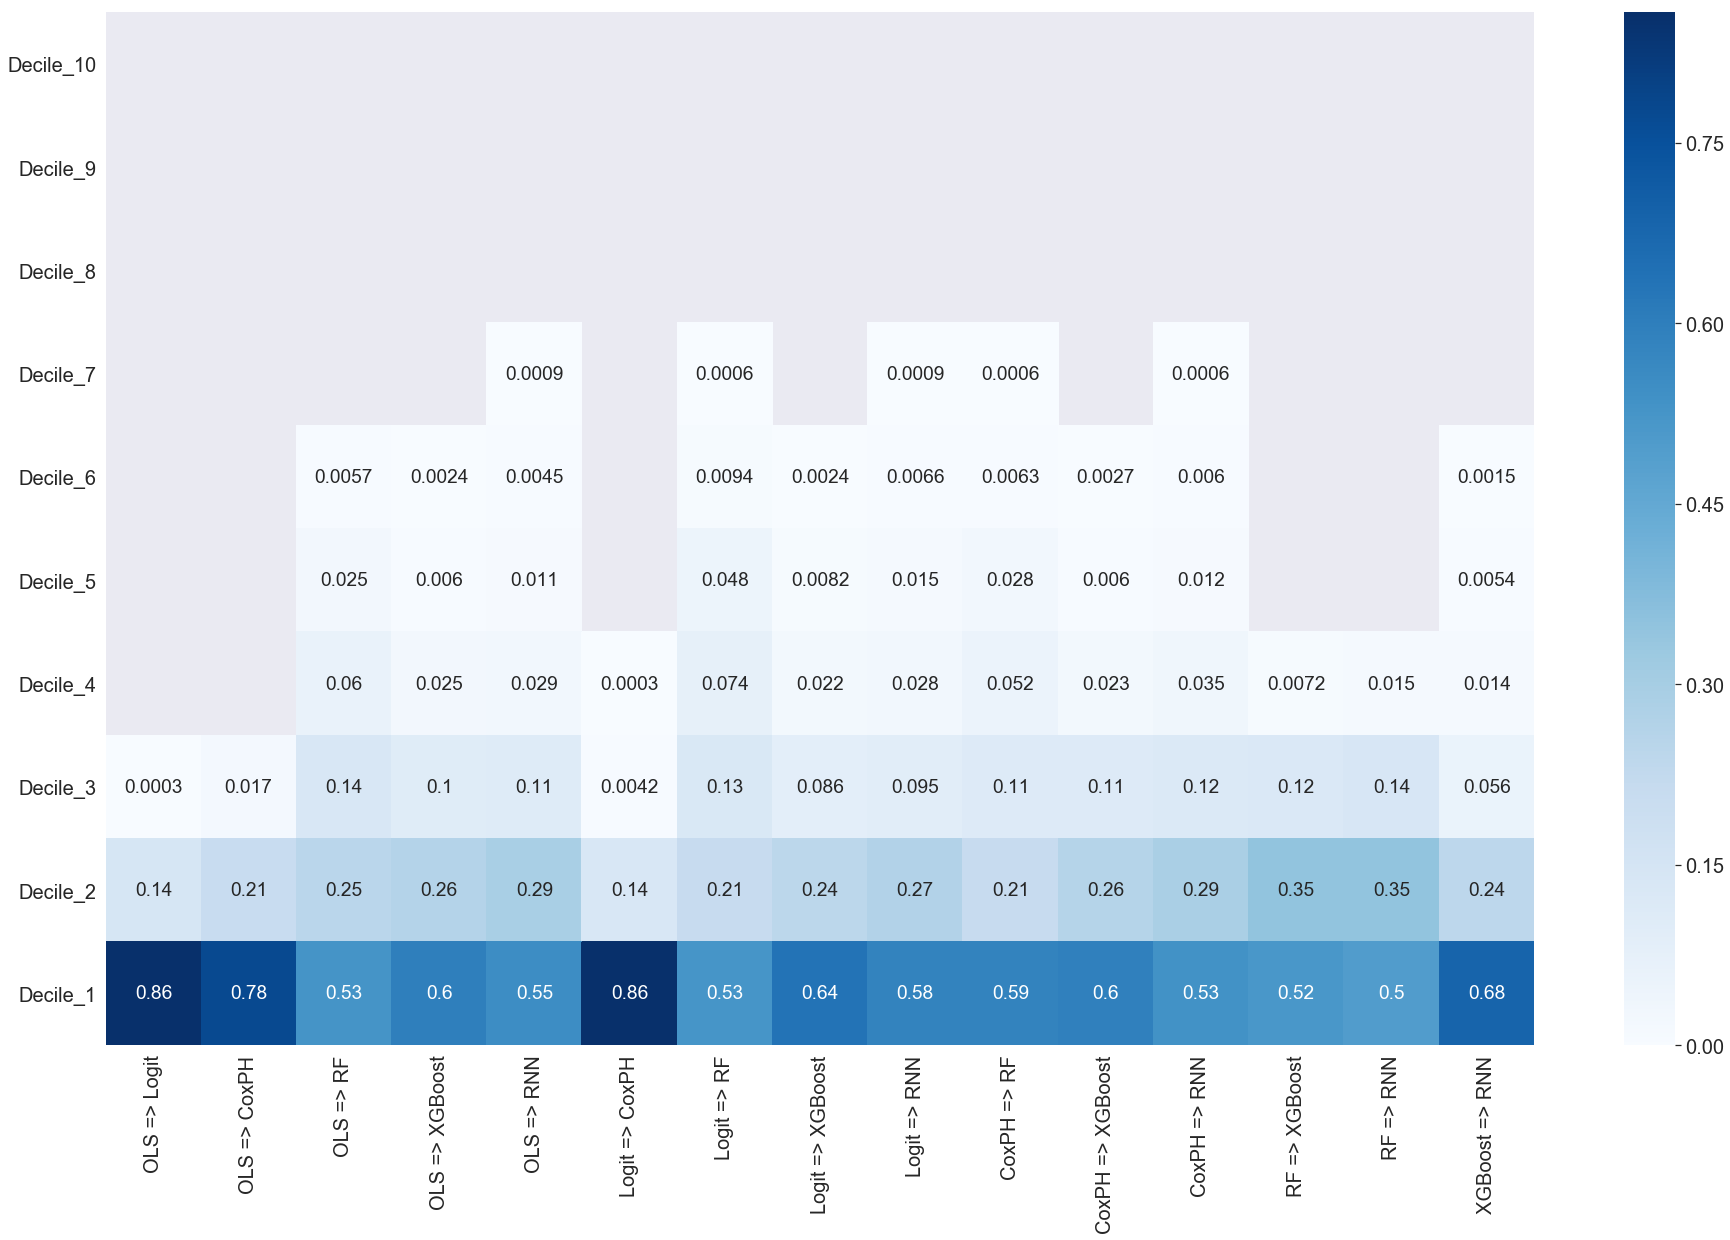

In [17]:
new_rr_dict={}
colnames = []
for i1,m1 in enumerate(m_list):
    for i2,m2 in enumerate(m_list):
        if i1 < i2:
            g1 = pred_decile_dict[m1]
            g2 = pred_decile_dict[m2]
            indx = np.where(np.array(g1)==10)[0]
            new_g2 = 11-np.array(g2)[indx]
            new_g2_cnt = Counter(new_g2)
            for i in range(1,11):
                if i not in new_g2_cnt:
                    new_g2_cnt[i] = 0
            new_g2_cnt = {k:round(v/len(indx),4) for k,v in new_g2_cnt.items()}
            colnames.append(m_dict[m1]+" => "+m_dict[m2])
            new_rr_dict[str(i1)+" => "+str(i2)] = new_g2_cnt
new_rr_df = pd.DataFrame.from_dict(new_rr_dict, orient='index').sort_index(ascending=True).T.sort_index(ascending=False)
new_rr_df.index = "Decile_" + new_rr_df.index.astype(str)
new_rr_df.columns = colnames
mask = np.where(new_rr_df==0, True, False)

plt.figure(figsize=(32,19))
g= sns.heatmap(new_rr_df, mask=mask, cmap="Blues",annot=True)
g.set_yticklabels(g.get_yticklabels(), rotation = 0, fontsize=20)
g.set_xticklabels(g.get_xticklabels(), rotation = 90, fontsize=20)
cbar = g.collections[0].colorbar
cbar.ax.tick_params(labelsize=20)
plt.savefig(output_fpath+"/pred_score_comparison/decile_change_2_heatmap_new_version.png", bbox='tight')
plt.show()

In [18]:
def nth_decile_heatmap(d):
    new_rr_dict={}
    colnames = []
    for i1,m1 in enumerate(m_list):
        for i2,m2 in enumerate(m_list):
            if i1 < i2:
                g1 = pred_decile_dict[m1]
                g2 = pred_decile_dict[m2]
                indx = np.where(np.array(g1)==(11-d))[0]
                new_g2 = 11-np.array(g2)[indx]
                new_g2_cnt = Counter(new_g2)
                for i in range(1,11):
                    if i not in new_g2_cnt:
                        new_g2_cnt[i] = 0
                new_g2_cnt = {k:round(v/len(indx),4) for k,v in new_g2_cnt.items()}
                colnames.append(m_dict[m1]+" => "+m_dict[m2])
                new_rr_dict[str(i1)+" => "+str(i2)] = new_g2_cnt
    new_rr_df = pd.DataFrame.from_dict(new_rr_dict, orient='index').sort_index(ascending=True).T.sort_index(ascending=False)
    new_rr_df.index = "Decile_" + new_rr_df.index.astype(str)
    new_rr_df.columns = colnames
    mask = np.where(new_rr_df==0, True, False)
    plt.figure(figsize=(32,19))
    g= sns.heatmap(new_rr_df, mask=mask, cmap="Blues",annot=True)
    g.set_yticklabels(g.get_yticklabels(), rotation = 0, fontsize=20)
    g.set_xticklabels(g.get_xticklabels(), rotation = 90, fontsize=20)
    cbar = g.collections[0].colorbar
    cbar.ax.tick_params(labelsize=20)
    plt.savefig(output_fpath+"/pred_score_comparison/decile_change_2_heatmap_new_version_bottom_{}.png".format(d),
                bbox='tight')
    plt.show()    

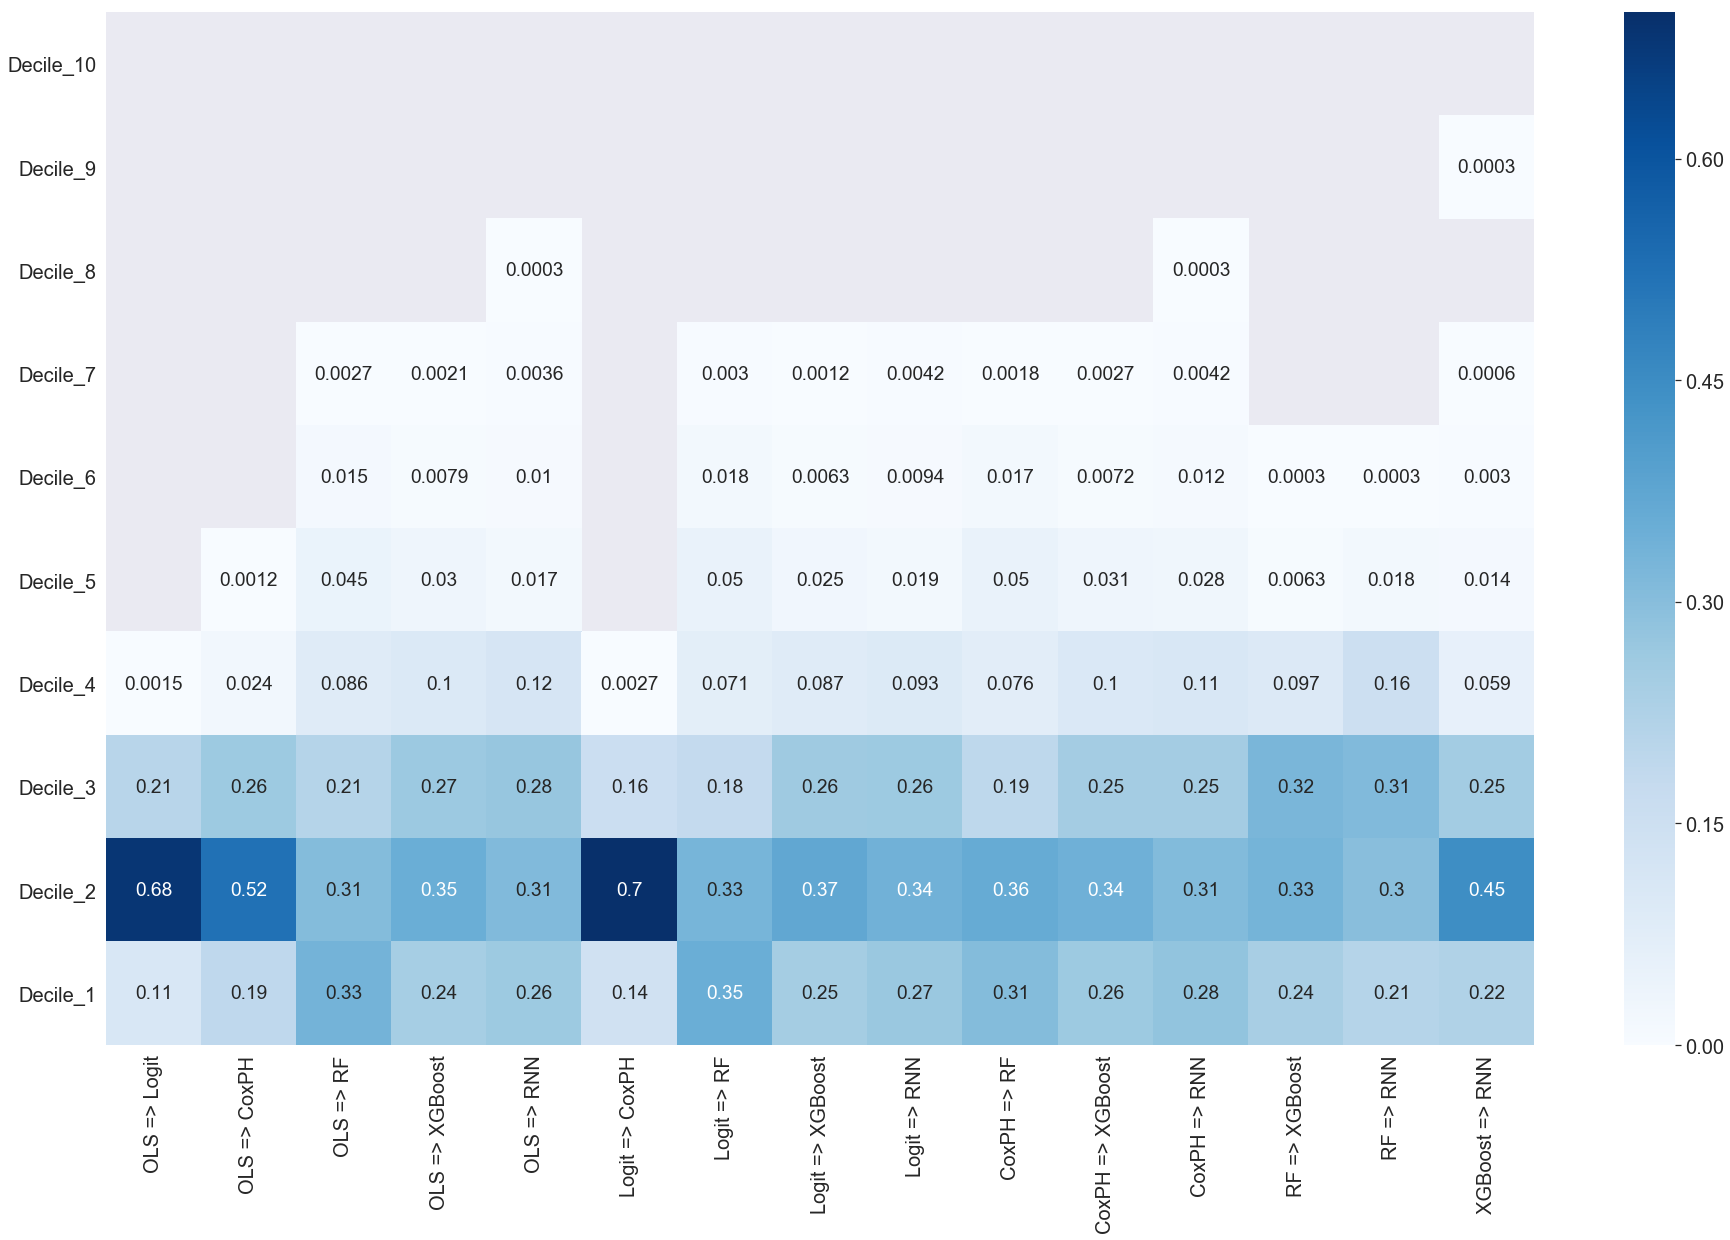

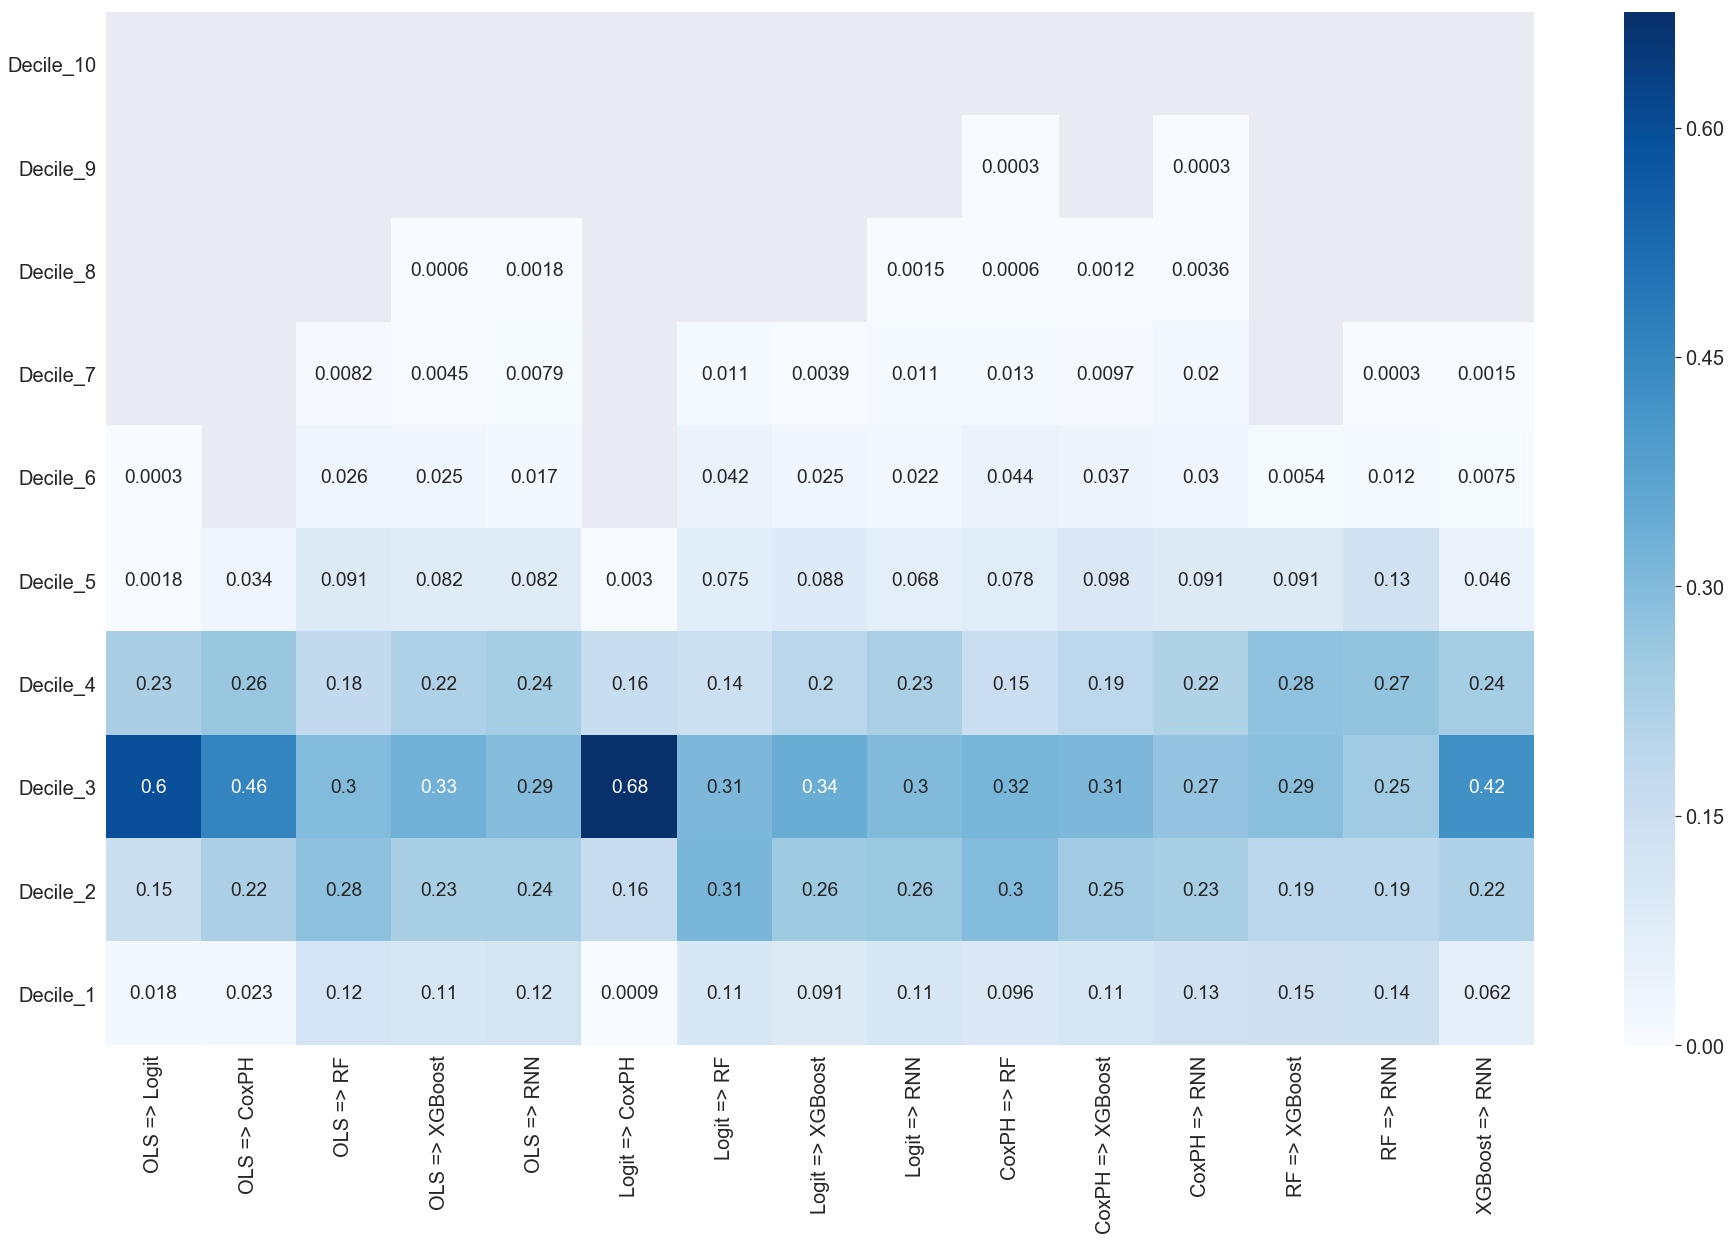

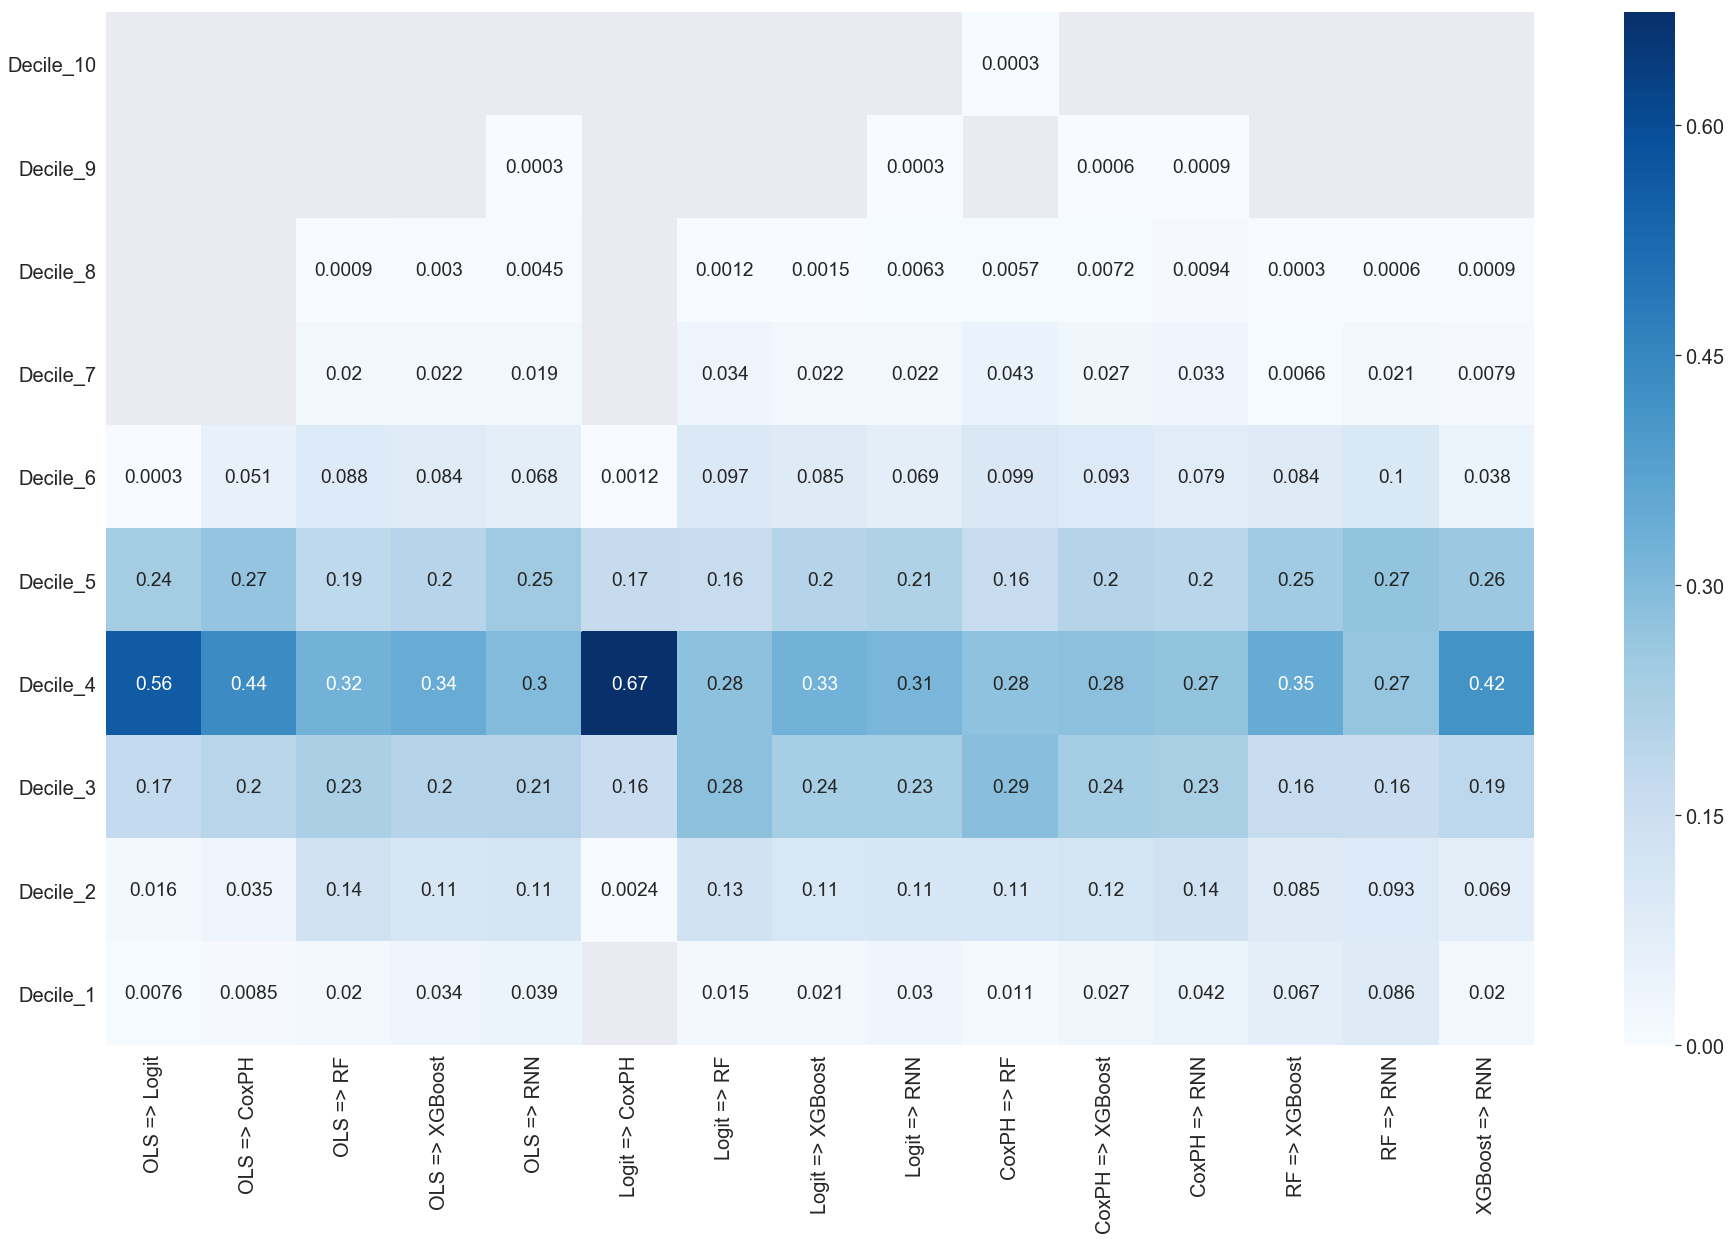

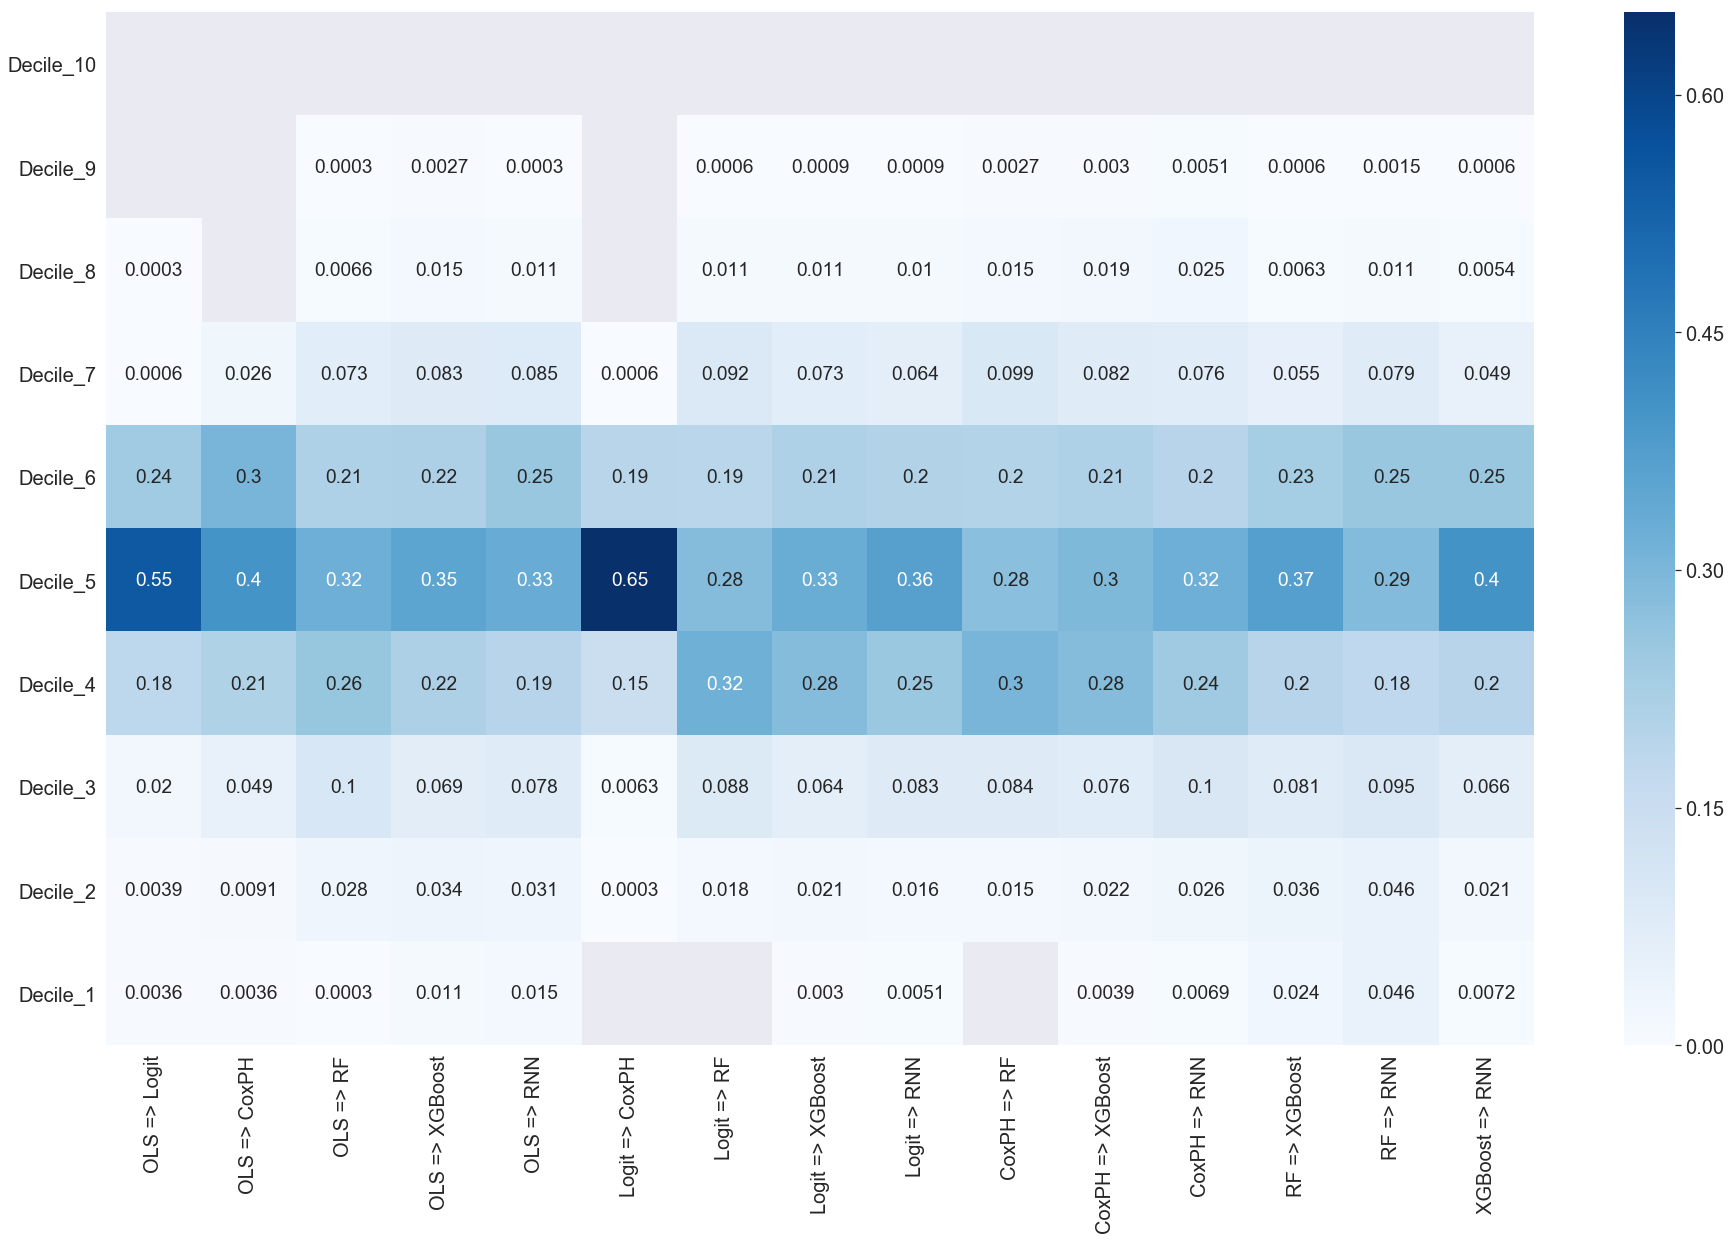

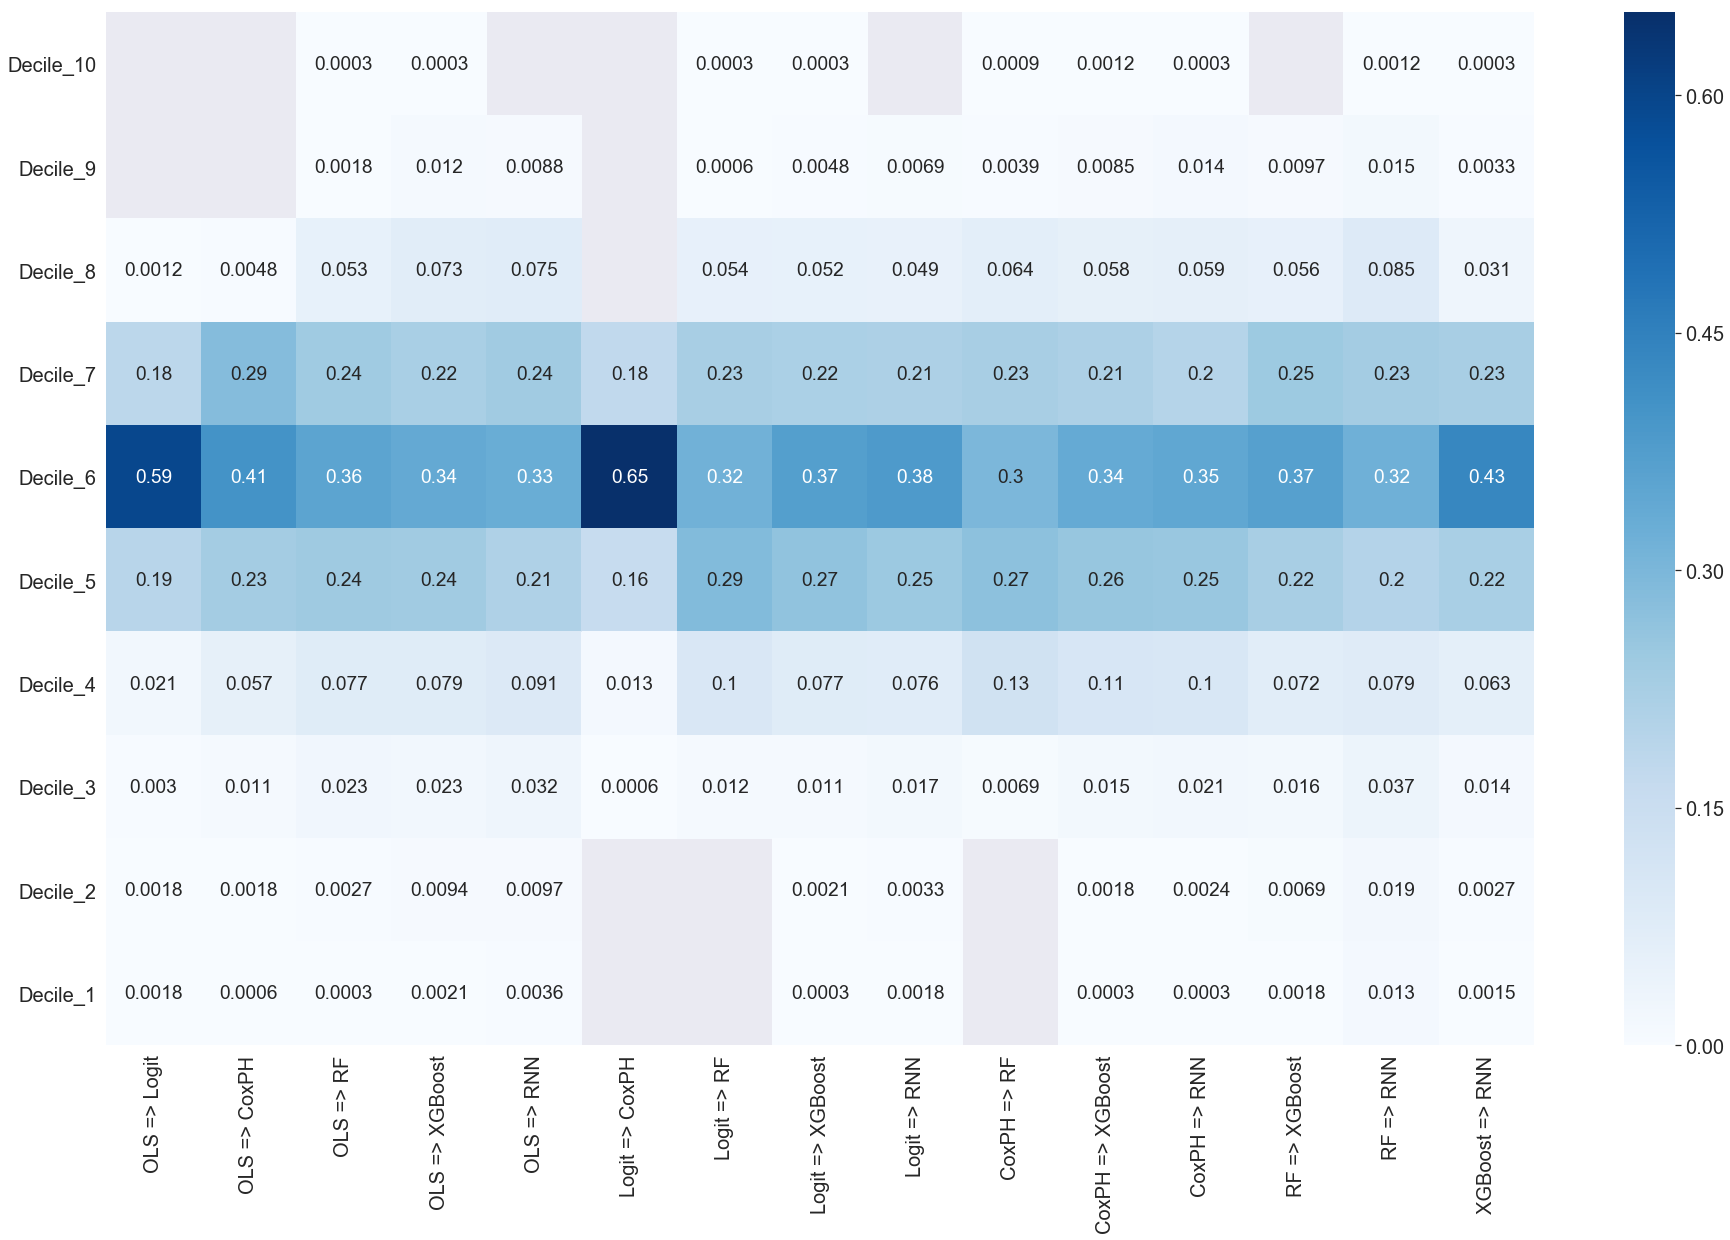

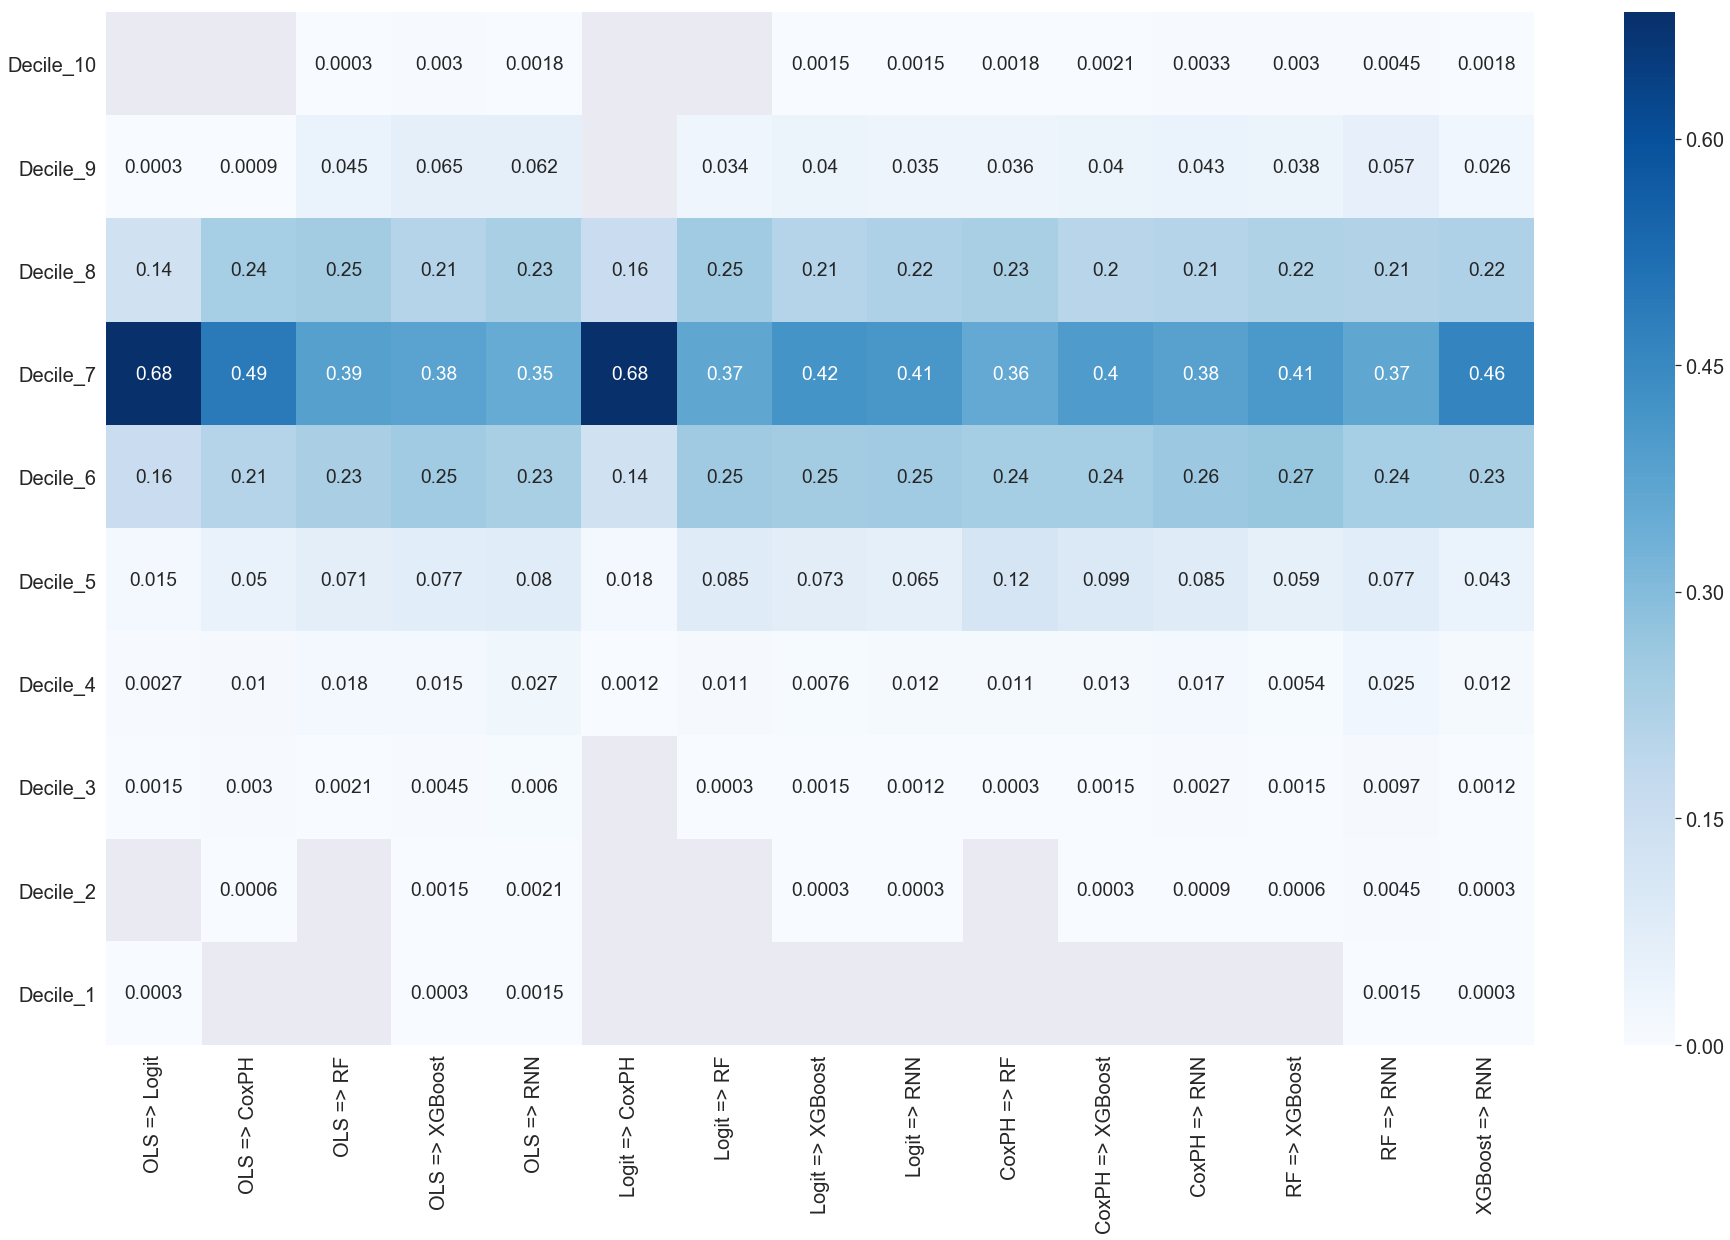

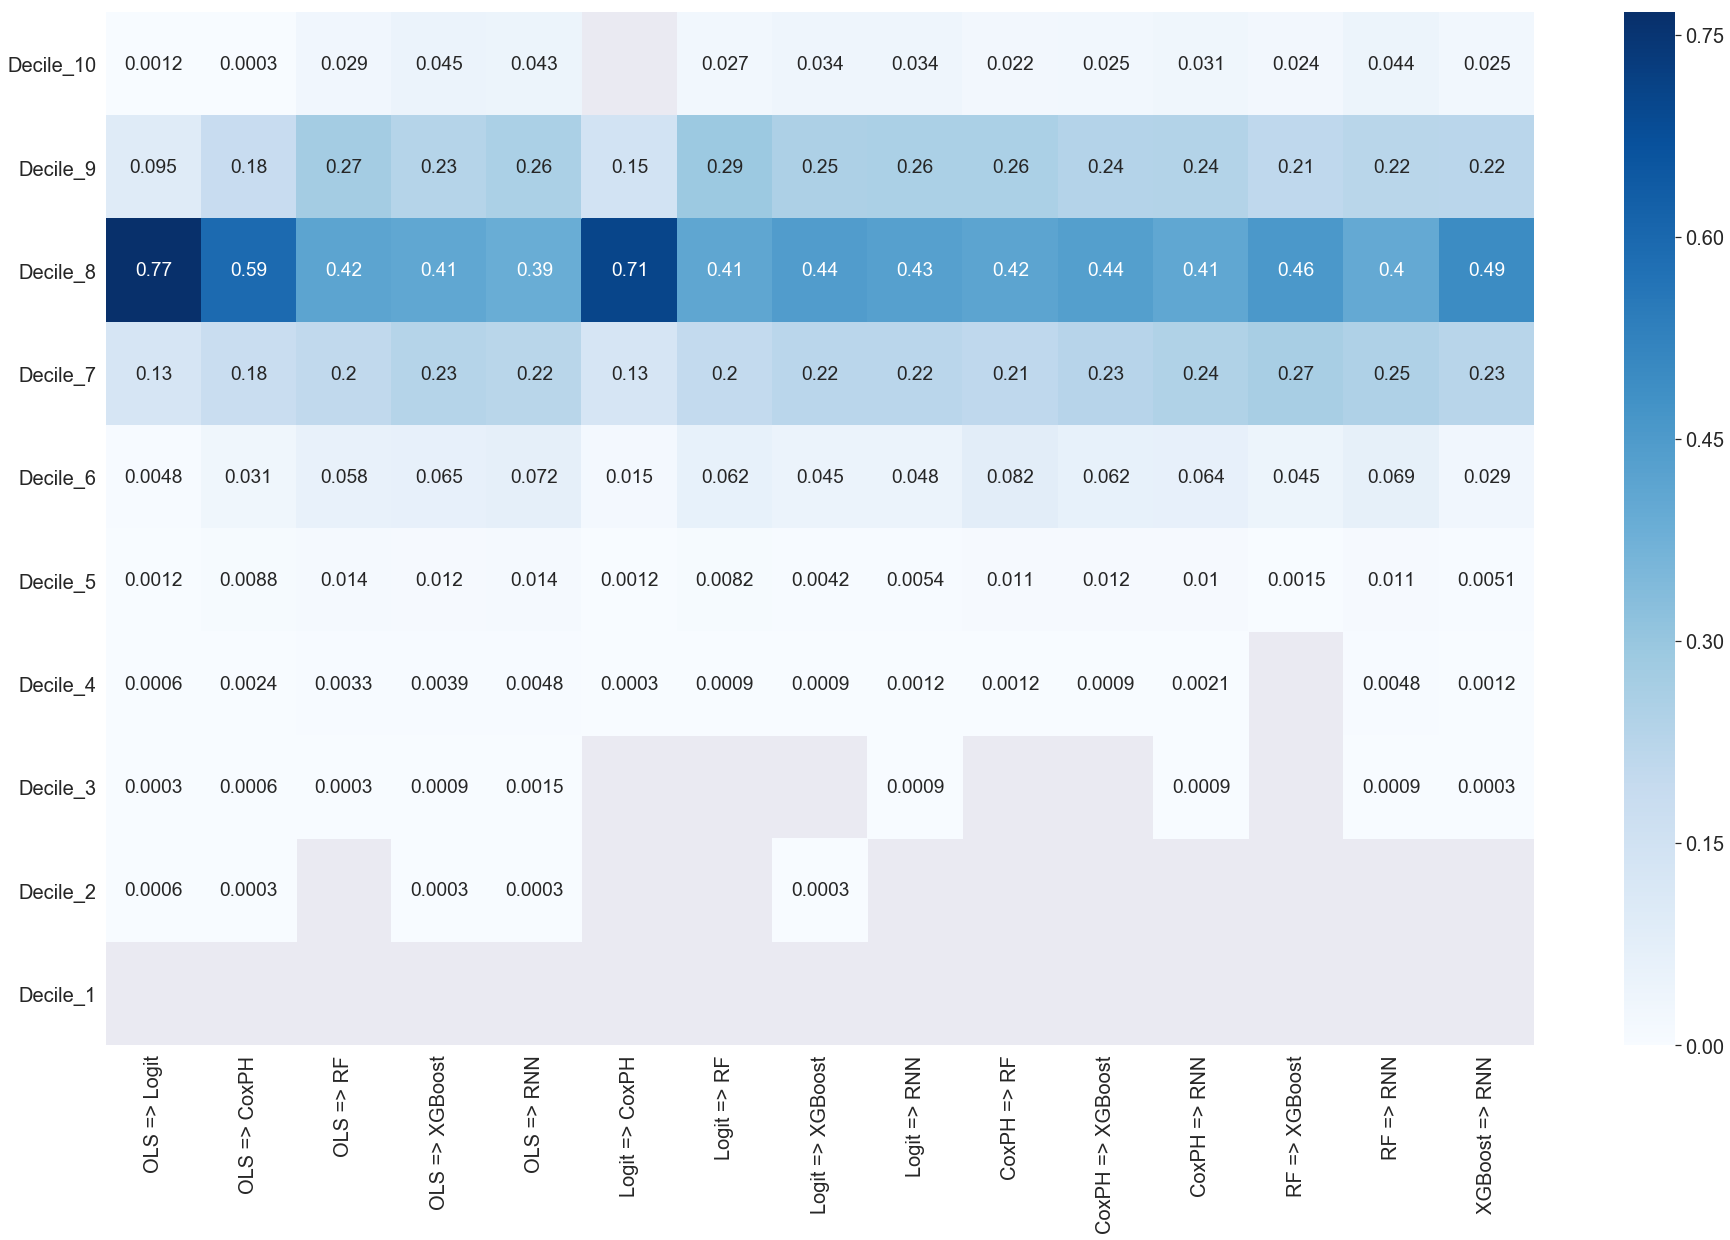

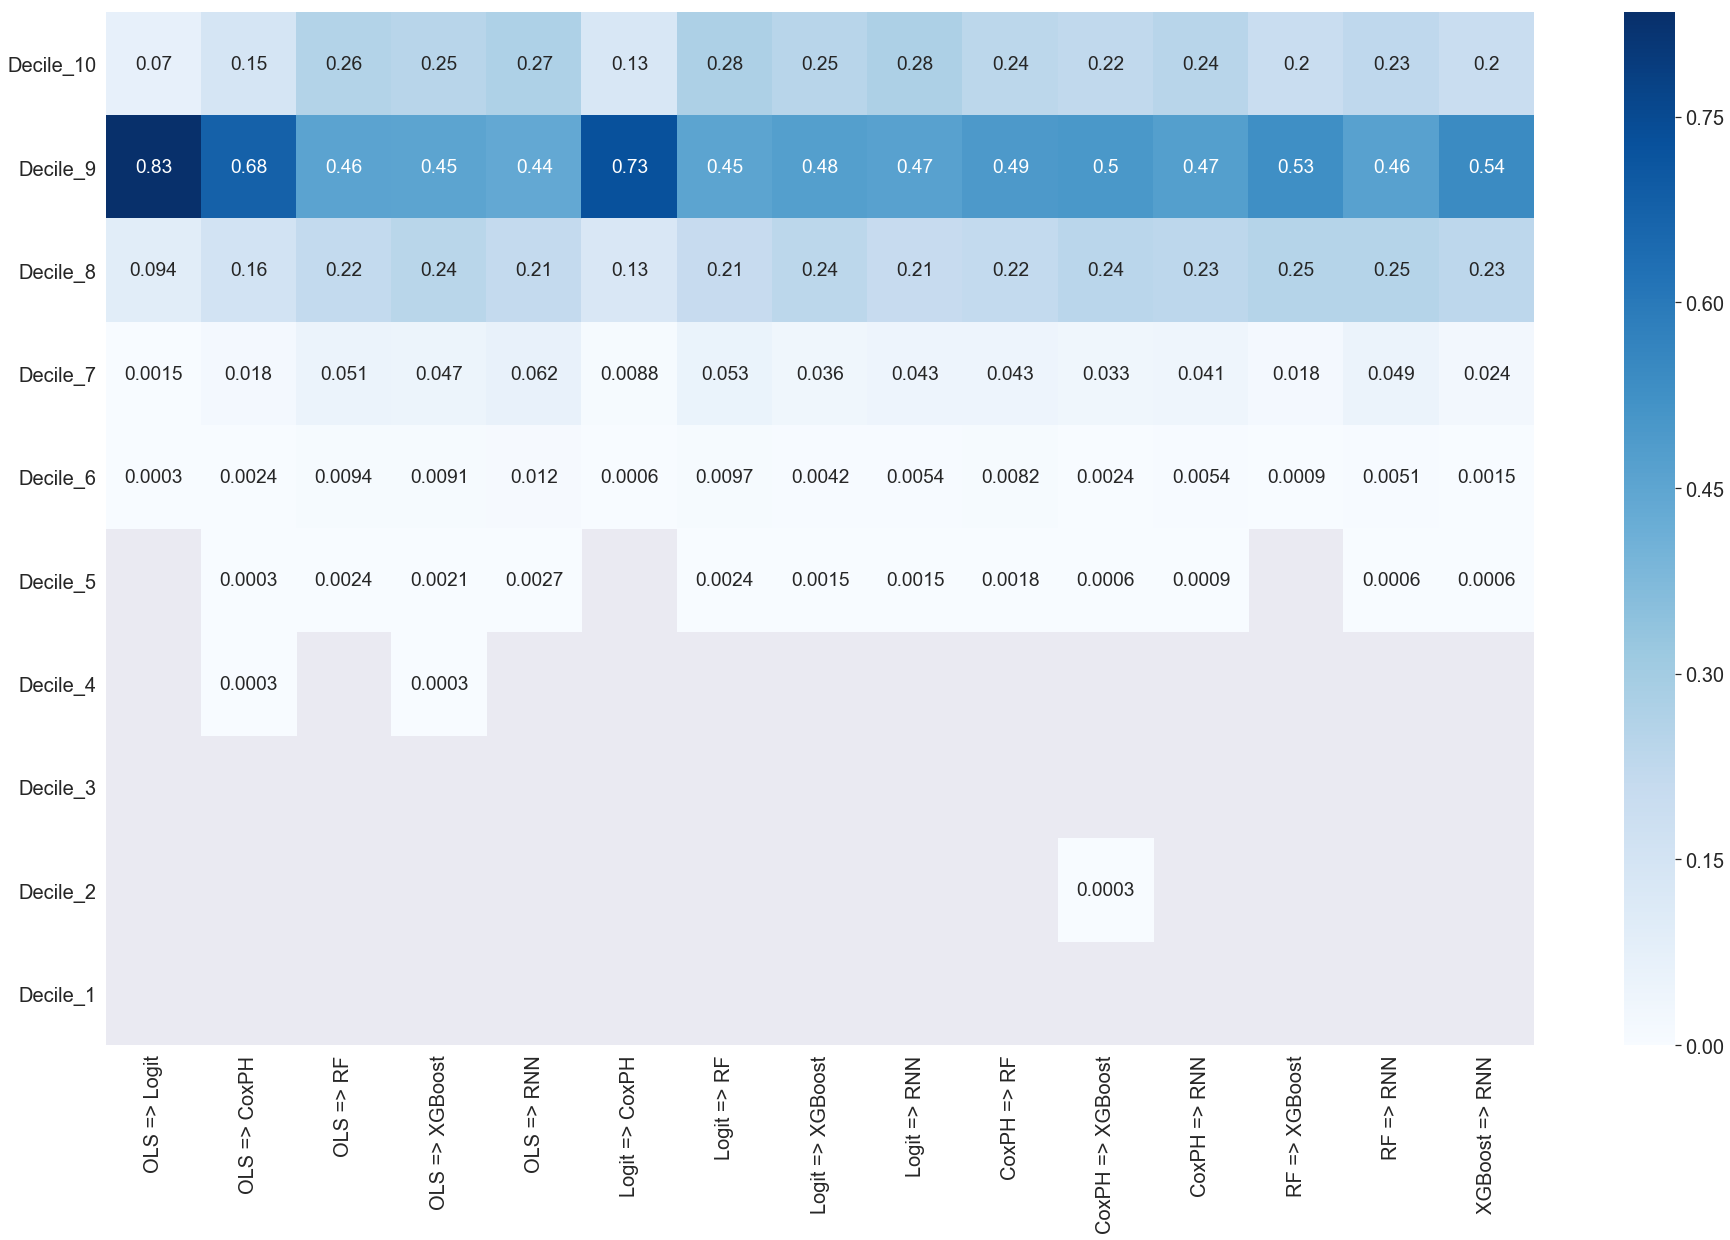

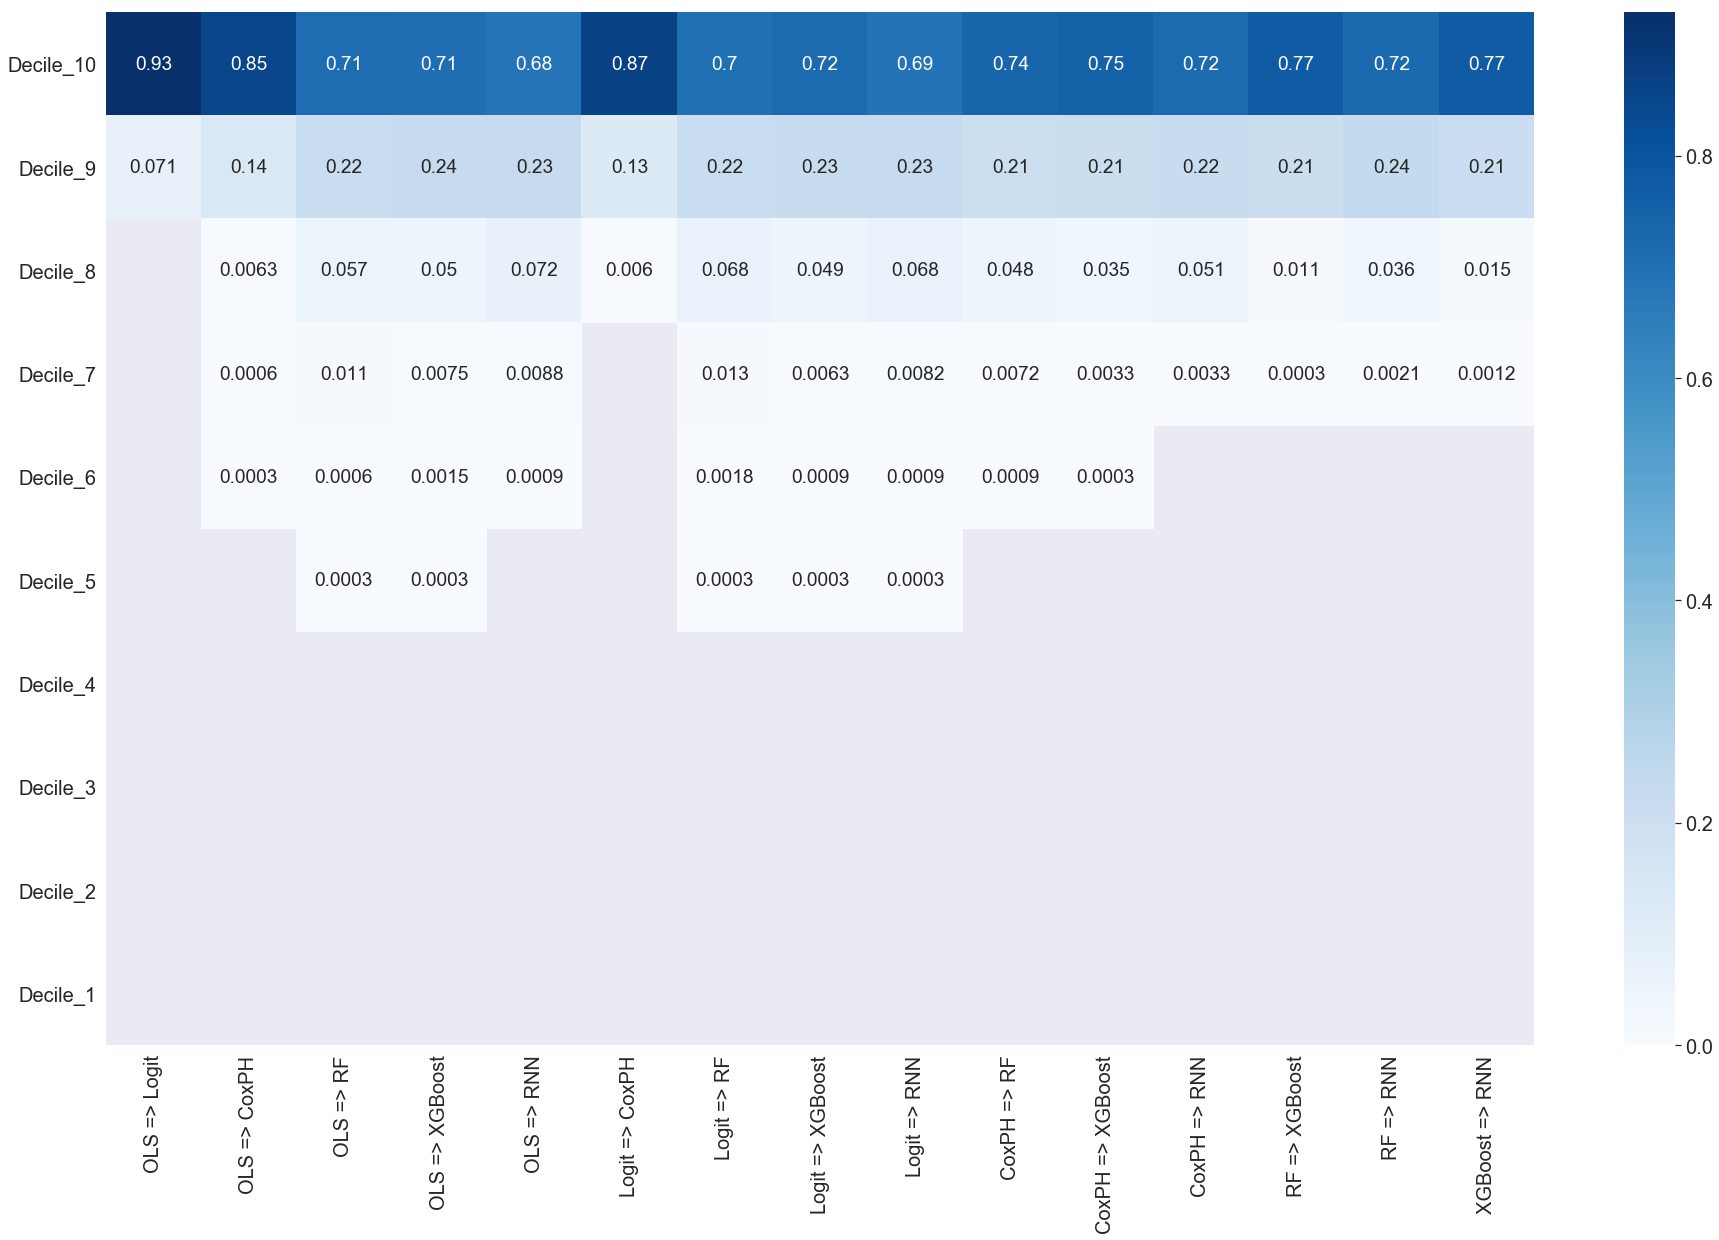

In [19]:
nth_decile_heatmap(2)
nth_decile_heatmap(3)
nth_decile_heatmap(4)
nth_decile_heatmap(5)
nth_decile_heatmap(6)
nth_decile_heatmap(7)
nth_decile_heatmap(8)
nth_decile_heatmap(9)
nth_decile_heatmap(10)

#### (2) Percentile Change Plot (for generating Figure 5 of the paper)

In [5]:
pred_percentile_dict = {}
for m in ['lr','ols','rf','xgb','rnn', 'coxph']:
    pred_percentile_dict[m] = \
    pd.cut(pred_dict[m], [-math.inf] + list(np.quantile(pred_dict[m], q=np.linspace(0.01,0.99,99))) + [math.inf],
           labels = range(100,0,-1)).astype(int)

In [6]:
all_g_diff = []
for i1,m1 in enumerate(m_list):
    for i2,m2 in enumerate(m_list):
        if i1 < i2:
            if (m1 == "ols" and m2 == "lr") == False and (m1 == "lr" and m2 == "coxph") == False:
                g1 = pred_percentile_dict[m1]
                g2 = pred_percentile_dict[m2]
                g_diff = list(np.array(g2) - np.array(g1))
                all_g_diff.extend(g_diff)

In [7]:
### Share of pairs of base models whose predicted percentiles differ by +10 or +20
sum(np.abs(all_g_diff) >= 10)/len(all_g_diff), sum(np.abs(all_g_diff) >= 20)/len(all_g_diff)

(0.3114019907315997, 0.06972206413547195)

In [32]:
rrr = []
for i1,m1 in enumerate(m_list):
    for i2,m2 in enumerate(m_list):
        if i1 < i2:
            g1 = pred_percentile_dict[m1]
            g2 = pred_percentile_dict[m2]
            g_diff = np.array(g2) - np.array(g1)
            t = [m1,m2,round(np.mean(g_diff),1),round(np.std(g_diff,ddof=1),1)] +\
            list(np.quantile(g_diff, q=[0.01,0.05,0.1,0.25,0.5,0.75,0.9,0.95,0.99]))
            rrr.append(tuple(t))
rrr_df = pd.DataFrame(rrr, columns=['Model_1', 'Model_2', 'Mean', 'Std_dev',
                                    '1%', '5%', '10%', '25%', 'Median', '75%', '90%', '95%', '99%'])
rrr_df.loc[:,'Model_1'] = rrr_df.Model_1.apply(lambda x: m_dict[x])
rrr_df.loc[:,'Model_2'] = rrr_df.Model_2.apply(lambda x: m_dict[x])
rrr_df.to_csv(output_fpath + "/pred_score_comparison/percentile_change.csv", index=False)
print(rrr_df)

    Model_1  Model_2  Mean  Std_dev    1%    5%   10%  25%  Median  75%   90%  \
0       OLS    Logit  -0.0      4.8  -9.0  -7.0  -6.0 -2.0     0.0  2.0   5.0   
1       OLS    CoxPH  -0.0      8.5 -17.0 -12.0  -9.0 -5.0     0.0  4.0   9.0   
2       OLS       RF   0.0     10.9 -31.0 -18.0 -13.0 -6.0     0.0  7.0  13.0   
3       OLS  XGBoost  -0.0     10.6 -27.0 -18.0 -13.0 -6.0     0.0  6.0  13.0   
4       OLS      RNN  -0.0     11.1 -27.0 -17.0 -13.0 -7.0     0.0  6.0  14.0   
5     Logit    CoxPH   0.0      6.0 -12.0  -8.0  -6.0 -3.0     0.0  2.0   6.0   
6     Logit       RF   0.0     11.2 -34.0 -20.0 -14.0 -6.0     1.0  7.0  13.0   
7     Logit  XGBoost   0.0      9.7 -26.0 -16.0 -12.0 -5.0     0.0  6.0  12.0   
8     Logit      RNN   0.0     10.3 -29.0 -16.0 -12.0 -6.0     0.0  6.0  12.0   
9     CoxPH       RF   0.0     11.9 -36.0 -21.0 -14.0 -6.0     1.0  7.0  14.0   
10    CoxPH  XGBoost   0.0     11.3 -32.0 -19.0 -13.0 -6.0     0.0  7.0  14.0   
11    CoxPH      RNN   0.0  

In [35]:
color_list = ["tab:blue"]*3 +["tab:orange"]*3 + ["tab:green"]*3 +["tab:red"]*3 + ["tab:purple"]*3 + ['tab:brown']*3
new_m_list = ['ols', 'lr', 'coxph', 'rf', 'xgb', 'rnn']
m_pairs = [(m1,m2) for i1,m1 in enumerate(new_m_list) for i2,m2 in enumerate(new_m_list) if i1 < i2]
m_pairs

[('ols', 'lr'),
 ('ols', 'coxph'),
 ('ols', 'rf'),
 ('ols', 'xgb'),
 ('ols', 'rnn'),
 ('lr', 'coxph'),
 ('lr', 'rf'),
 ('lr', 'xgb'),
 ('lr', 'rnn'),
 ('coxph', 'rf'),
 ('coxph', 'xgb'),
 ('coxph', 'rnn'),
 ('rf', 'xgb'),
 ('rf', 'rnn'),
 ('xgb', 'rnn')]

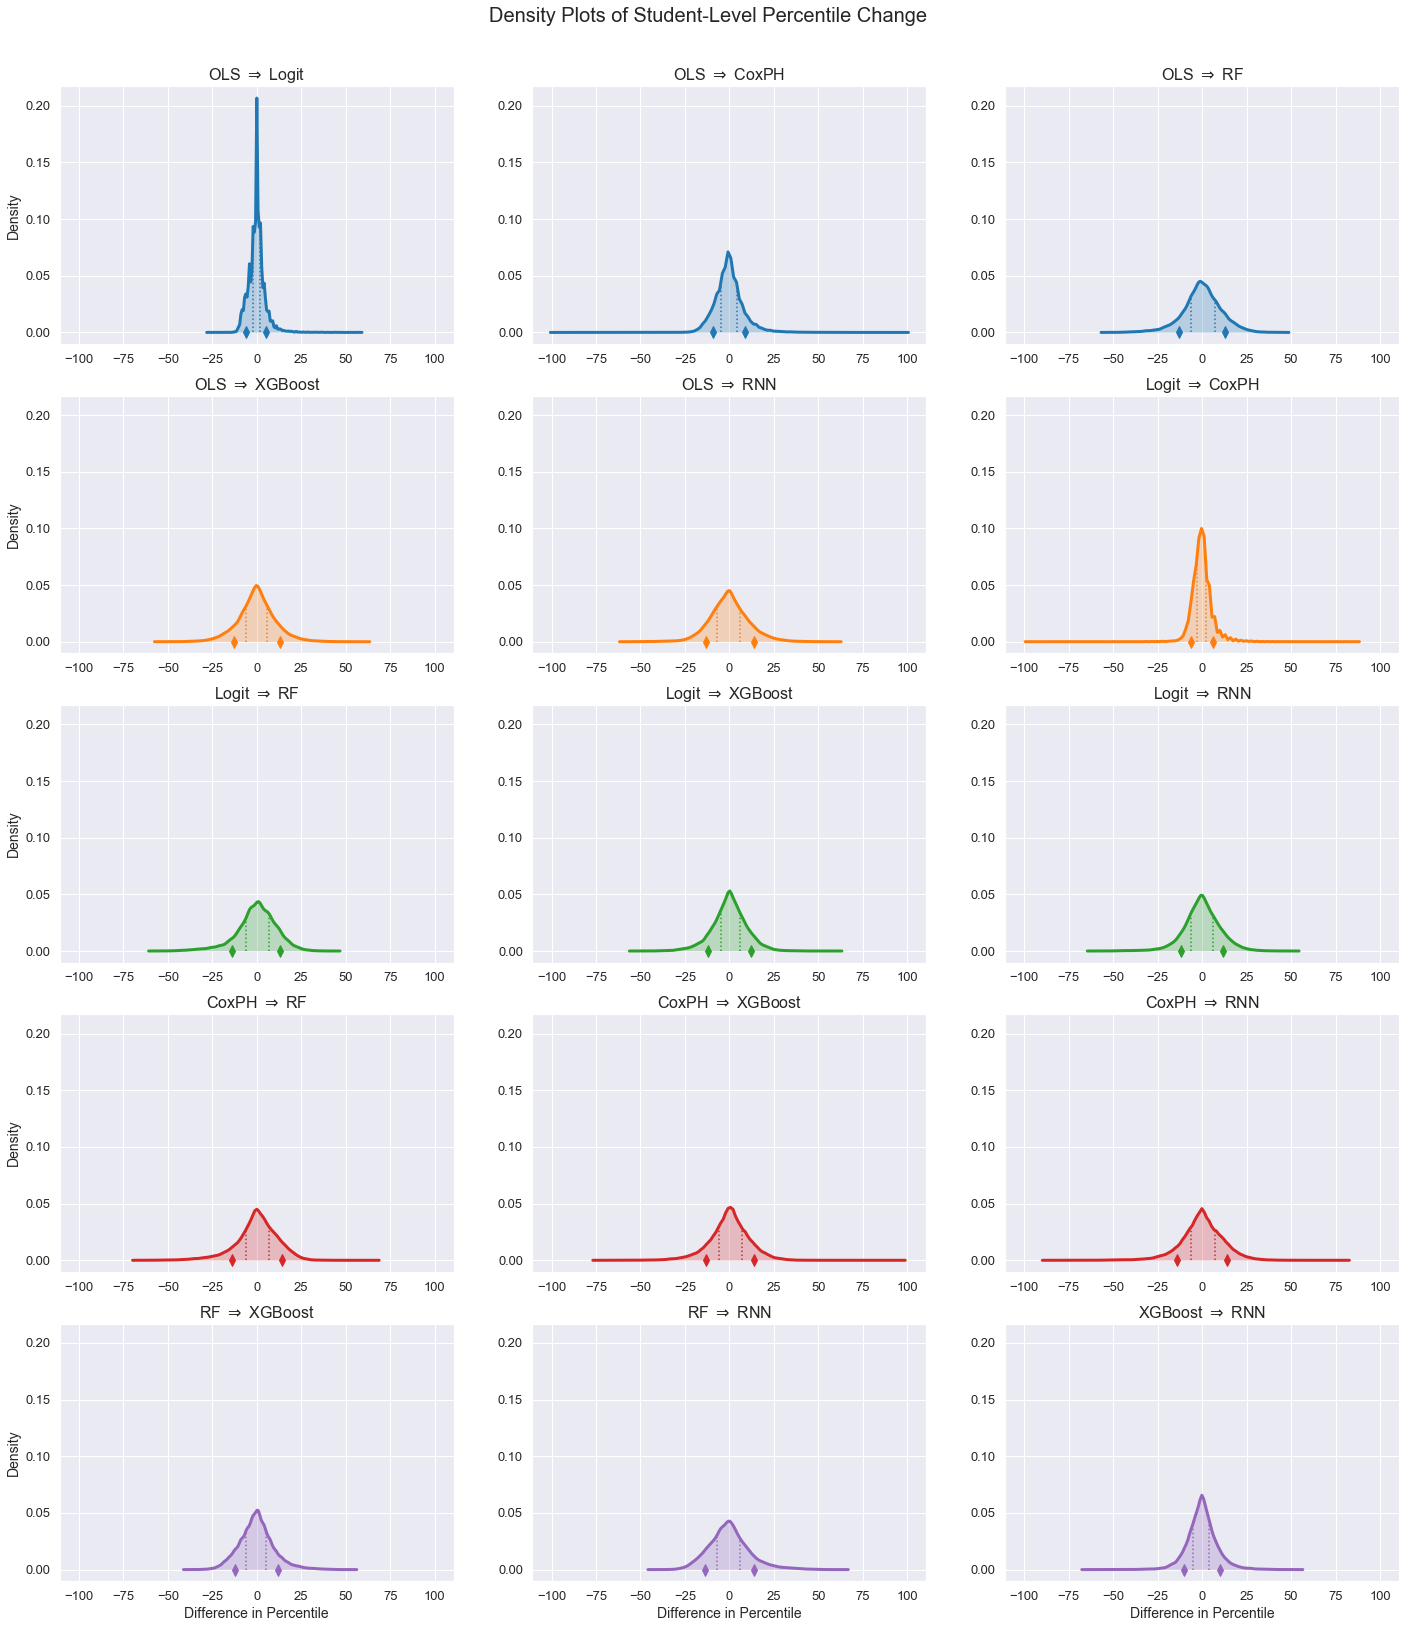

In [38]:
sns.set(style="darkgrid", palette="muted", color_codes=True)
f, axes = plt.subplots(5, 3, figsize=(24, 27.5), sharex=True, sharey=True)
f.suptitle("Density Plots of Student-Level Percentile Change", fontsize=20, y=0.92)
for indx,((m1,m2),c) in enumerate(zip(m_pairs, color_list)):
    i = indx // 3
    j = indx % 3
    g1 = pred_percentile_dict[m1]
    g2 = pred_percentile_dict[m2]
    g_diff = np.array(g2) - np.array(g1)
    t = m_dict[m1] + " $\Rightarrow$ " + m_dict[m2]    
    g_obj = sns.distplot(g_diff, hist=False, color=c, kde_kws={"shade": True, 'lw':3}, ax=axes[i,j])
    axes[i,j].set_title(t,fontsize=16)
    axes[i,j].tick_params(labelbottom=True, labelleft=True)
    axes[i,j].tick_params(axis="x", labelsize=13)
    axes[i,j].tick_params(axis="y", labelsize=13)
    q1,q2 = np.quantile(g_diff, [0.25,0.75])
    kde_x = g_obj.get_lines()[0].get_data()[0]
    i1 = np.where(kde_x > q1)[0][0]
    y1 = (g_obj.get_lines()[0].get_data()[1][i1-1]+g_obj.get_lines()[0].get_data()[1][i1])/2
    i2 = np.where(kde_x > q2)[0][0]
    y2 = (g_obj.get_lines()[0].get_data()[1][i2-1]+g_obj.get_lines()[0].get_data()[1][i2])/2
    axes[i,j].vlines(q1,0,y1,color=c,linestyle='dotted')
    axes[i,j].vlines(q2,0,y2,color=c,linestyle='dotted')
    q3,q4 = np.quantile(g_diff, [0.1,0.9])
    axes[i,j].plot(q3,0,marker='d',markersize=8,color=c)
    axes[i,j].plot(q4,0,marker='d',markersize=8,color=c) 
    if j == 0:
        axes[i,j].set_ylabel("Density", fontsize=14)
    if i == 4:
        axes[i,j].set_xlabel("Difference in Percentile", fontsize=14)
plt.savefig(output_fpath + "/pred_score_comparison/percentile_change_density_plot.png", bbox_inches="tight")
plt.show()

#### (3) Precision & Recall within different quantiles (1st, 3rd and 5th bottom deciles) -- used to create Figure 7 of the paper

In [5]:
df = pd.read_stata(fpath + "/full_data_truncated.dta")
y_test = df[df.valid == 1].loc[:,['vccsid','grad_6years']].rename(columns={'grad_6years':'y_real'})

In [6]:
pred_dict_new = {}
for k,v in pred_dict.items():
    pred_dict_new[k] = [(v[i], y_test.iloc[i,1], y_test.iloc[i,0]) for i in range(y_test.shape[0])]

In [7]:
num_of_1 = sum(y_test.y_real)
num_of_0 = len(y_test.y_real) - sum(y_test.y_real)

In [8]:
def q_pr_new(outcome, quantile, model):
    new_t = pred_dict_new[model][:]
    if outcome == 1:
        new_t = sorted(new_t, key = lambda x: x[0]*(-1))
    if outcome == 0:
        new_t = sorted(new_t, key = lambda x: x[0])
    l1 = int(round(len(new_t)*(quantile-0.1)))
    l2 = int(round(len(new_t)*quantile))
    sub_t = new_t[l1:l2]
    p = sum([t[1] == outcome for t in sub_t])/(l2-l1)
    r = sum([t[1] == outcome for t in sub_t])/eval("num_of_{}".format(outcome))
    return round(p,4), round(r,4)

In [9]:
results_r = []
for quantile in [0.1,0.3,0.5]:
    for m in ['lr','ols','coxph','rf','xgb','rnn']:
        p,r = q_pr_new(0, quantile, m)
        results_r.append((quantile,p,r))

In [12]:
df = pd.DataFrame(results_r, columns=['quantile', 'precision_0', 'recall_0'])
df.loc[:,'model'] = ['Logit', 'OLS', 'Cox Proportional Hazard', 'Random Forest', 'XGBoost', 'RNN']*3
df = df.iloc[:,[-1]+list(range(df.shape[1]-1))]
df.loc[:,'quantile'] = df['quantile']*10
df.loc[:,'quantile'] = df['quantile'].astype(int)
df.to_csv(output_fpath + "/precision_recall_by_quantile/1st_3rd_5th_deciles.csv", index=False)

In [13]:
df

,model,quantile,precision_0,recall_0
0,Logit,1,0.9768,0.1483
1,OLS,1,0.9737,0.1479
2,Cox Proportional Hazard,1,0.9689,0.1471
3,Random Forest,1,0.9728,0.1477
4,XGBoost,1,0.9828,0.1493
5,RNN,1,0.9798,0.1488
6,Logit,3,0.9333,0.1417
7,OLS,3,0.9357,0.1421
8,Cox Proportional Hazard,3,0.9278,0.1409
9,Random Forest,3,0.9348,0.1419
